In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import skimage.transform
import skimage.measure
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.measure import block_reduce
import scipy
from scipy.io import savemat
from scipy.spatial.distance import euclidean
from scipy.signal import fftconvolve,correlate
import pandas as pd
import pickle
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import csv

import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
ds = 2
save_path = "downsampled_data_naip"+str(ds)+"/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def fn(i):
    return paths[i].replace('/','-')[:-7]

def disp(pic):
    pic = np.rollaxis(np.squeeze(pic),0,3)
    plt.figure(figsize=(6,6))
    plt.imshow(pic)
    plt.axis('off')
    plt.show()
    plt.close()

def ds_data(num):    
    space = 0.
    s = float(time.time())
    for i in range(num):
        if (i%5==4):
            print("Tile %i of %i. Time: %.2f s. Space: %.2f MB" % (i+1,num,float(time.time())-s,space/1024**2))
        naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+fn(i).replace('-','/')+".mrf",'r')
        naip = naip_tile.read()[:3,:,:].astype(np.float)/255
        naip_tile.close()
        naip = block_reduce(naip,(1,ds,ds),np.mean)
        path_im = save_path + fn(i)+'.npz'
        np.savez_compressed(path_im,a=naip)
        space += os.stat(path_im).st_size
    fin_time = float(time.time())-s
    fin_size = space/1024**2
    print("Finished! Time: %.2f s. Space: %.2f MB" % (fin_time,fin_size))
    print("Averaged %.3f seconds, %.0f KB per tile" % (fin_time/num,1024*fin_size/num))
    
def data_conglomerate(num):
    maxx_ds = 7800//ds
    maxy_ds = 6400//ds
    s = float(time.time())
    total = np.zeros((num,3,maxx_ds,maxy_ds),dtype=np.float)
    for i in range(num):
        if (i%5==4):
            print("Tile %i of %i. Time: %.2f s" % (i+1,num,float(time.time())-s))
        naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+fn(i).replace('-','/')+".mrf",'r')
        naip = naip_tile.read()[:3,:,:].astype(np.float)/255
        naip_tile.close()
        reduced = skimage.measure.block_reduce(naip,(1,ds,ds),np.mean)
        tile = np.pad(reduced,((0,0),(0,maxx_ds-reduced.shape[1]),(0,maxy_ds-reduced.shape[2])),mode='constant')
        total[i] = tile
    path_im = save_path + 'total.npz'
    np.savez_compressed(path_im,a=total)
    print(total.shape)
    print("Total space taken: %f MB" % (os.stat(path_im).st_size/1024**2))

In [4]:
#ds_data(10)

In [5]:
%%time
#data_conglomerate(10)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [4]:
%%time
all_tiles = np.load(save_path+'total.npz')['a']
print(all_tiles.shape)
tile_torch = torch.from_numpy(all_tiles).float().to(device0)

(10, 3, 3900, 3200)
CPU times: user 13 s, sys: 1.6 s, total: 14.6 s
Wall time: 42.6 s


In [5]:
def cum_sum(arr, s):
    cumsum = np.cumsum(np.cumsum(arr,axis=2),axis=3)
    cumsum = np.pad(cumsum,((0,0),(0,0),(1,0),(1,0)),'constant')
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def conv_lookup(searched_tiles,query,device): 
    query_squared = torch.Tensor([np.sum(query**2)]).float().to(device)
    conv = F.conv2d(tile_torch[searched_tiles,:,:,:],torch.from_numpy(query).float().to(device))
    torch.cuda.empty_cache()
    conv = torch.transpose(conv,0,1)
    conv = torch.add(tiles_squared[searched_tiles,:,:],-2,conv)
    #torch.cuda.empty_cache()
    conv = torch.add(conv,query_squared)
    #torch.cuda.empty_cache()
    #conv = tiles_squared[searched_tiles,:,:]-2*conv+query_squared
    return conv

lc_path = 'downsampled_data'+str(ds)+'/'
def get_labels(t,x,y,size):
    tile = np.load(lc_path+fn(t)+'.npz')['a']
    return tile[x:x+size,y:y+size]

def get_labels_loaded(t,x,y,size):
    try:
        labels_matrix
    except NameError:
        print("labels_matrix not initialized!")
    else:
        return labels_matrix[t][x:x+size,y:y+size]

def make_labels(num):
    labels_dict = {}
    for i in range(num):
        labels_dict[i] = np.load(lc_path+fn(i)+'.npz')['a']
    return labels_dict

def get_query(t,x,y,size):
    try:
        all_tiles
    except NameError:
        print("all_tiles not initialized!")
    else:
        return np.expand_dims(all_tiles[t,:,x:x+size,y:y+size],axis=0)
    
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
def disp_label(pic):
    plt.figure(figsize=(6,6))
    plt.imshow(palette[pic])
    plt.axis('off')
    plt.show()
    plt.close()

def get_nns(tiles,list_tiles,nns):
    coords = []
    tiles = tiles.cpu().numpy()
    ind = np.argpartition(tiles,nns,axis=None)[:nns]
    for i in range(len(ind)):
        t,z1,z2 = np.unravel_index(ind[i],(tiles.shape))
        dist = tiles[t,z1,z2]
        t = list_tiles[t]
        coords.append((t,z1,z2,dist))
    return coords

def get_subpatches(pic):
    pic_size = pic.shape[3]
    to_return = np.zeros((1,3,size,size))
    for i in range(pic_size-size+1):
        for j in range(pic_size-size+1):
            temp = pic[:,:,i:i+size,j:j+size]
            to_return = np.concatenate((to_return,temp),axis=0)
    return to_return[1:,:,:,:]

In [6]:
%%time
labels_matrix = make_labels(10)

CPU times: user 418 ms, sys: 23 ms, total: 441 ms
Wall time: 1.59 s


In [9]:
%%time
size = 4
tiles_squared = torch.from_numpy(np.sum(cum_sum(all_tiles**2,size),axis=1)).float().to(device1)
print(tiles_squared.shape)

torch.Size([10, 3897, 3197])
CPU times: user 9.77 s, sys: 5.04 s, total: 14.8 s
Wall time: 14.8 s


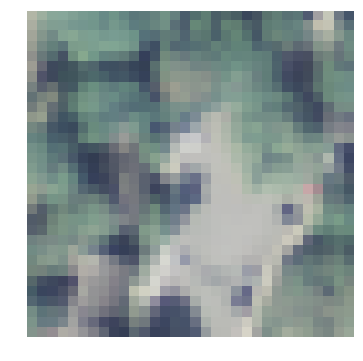

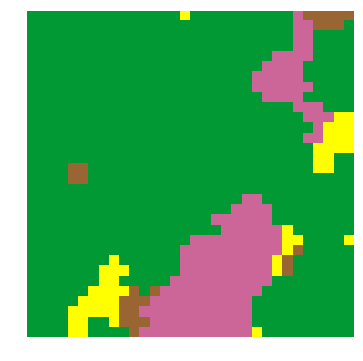

(1, 3, 32, 32)
(841, 3, 4, 4)


In [10]:
t,x,y,bigsize = 0, 2100, 2100, 32
query_tile = get_query(t,x,y,bigsize)
disp(query_tile)
ground_truth = get_labels_loaded(t,x,y,bigsize)
disp_label(ground_truth)
print(query_tile.shape)
subpatches = get_subpatches(query_tile)
print(subpatches.shape)
final_labels = np.zeros((bigsize,bigsize,7),dtype=int)

In [11]:
def reconstruct(subpatches):
    max_load = 6
    num_nns = 5
    searched_tiles = np.arange(9)+1#np.arange(10)#
    s=0
    all_nns = []
    while s*max_load < subpatches.shape[0]:
        time0 = float(time.time())
        to_conv = subpatches[s*max_load:(s+1)*max_load,:,:,:]
        conv0 = conv_lookup(searched_tiles,to_conv,device0)
        torch.cuda.empty_cache()
        time1 = float(time.time())
        print('Convolution %i in %.3f seconds' % (s+1,time1-time0))
        for curr_subpatch in range(conv0.shape[0]):
            nns = get_nns(conv0[curr_subpatch],searched_tiles,num_nns)
            all_nns.append(nns)
            #torch.cuda.empty_cache()
            temp_bins = np.zeros((size,size,1),dtype=int)
            for j in nns:
                labels = get_labels_loaded(j[0],j[1],j[2],size)
                if labels.shape==(size,size):
                    temp_count = np.expand_dims(labels,axis=2)
                    temp_bins = np.concatenate((temp_bins,temp_count),axis=2)
            temp_bins = temp_bins[:,:,1:]
            temp_counted = np.zeros((size,size,7),dtype=int)
            for i in range(size):
                for j in range(size):
                    temp_counted[i,j] = np.bincount(temp_bins[i,j],minlength=7)
            idx0,idx1 = np.unravel_index(curr_subpatch+s*max_load,(bigsize-size+1,bigsize-size+1))
            #print(idx0,idx1)
            final_labels[idx0:idx0+size,idx1:idx1+size] += temp_counted
        print('%i pixels sorted in %.3f seconds' % (conv0.shape[0],float(time.time()-time1)))
        s += 1
    return final_labels, all_nns

In [12]:
%%time
#final_labels, all_nns = reconstruct(subpatches)
cProfile.run('final_labels,all_nns = reconstruct(subpatches)')

Convolution 1 in 1.377 seconds
6 pixels sorted in 5.678 seconds
Convolution 2 in 1.471 seconds
6 pixels sorted in 6.357 seconds
Convolution 3 in 1.261 seconds
6 pixels sorted in 6.111 seconds
Convolution 4 in 1.505 seconds
6 pixels sorted in 5.530 seconds
Convolution 5 in 1.375 seconds
6 pixels sorted in 6.240 seconds
Convolution 6 in 1.475 seconds
6 pixels sorted in 5.786 seconds
Convolution 7 in 1.254 seconds
6 pixels sorted in 5.676 seconds
Convolution 8 in 1.384 seconds
6 pixels sorted in 6.257 seconds
Convolution 9 in 1.363 seconds
6 pixels sorted in 6.029 seconds
Convolution 10 in 1.108 seconds
6 pixels sorted in 5.334 seconds
Convolution 11 in 1.306 seconds
6 pixels sorted in 5.825 seconds
Convolution 12 in 1.525 seconds
6 pixels sorted in 5.782 seconds
Convolution 13 in 1.247 seconds
6 pixels sorted in 6.463 seconds
Convolution 14 in 1.421 seconds
6 pixels sorted in 6.396 seconds
Convolution 15 in 1.322 seconds
6 pixels sorted in 5.658 seconds
Convolution 16 in 1.290 seconds
6 

Convolution 127 in 1.263 seconds
6 pixels sorted in 6.482 seconds
Convolution 128 in 1.318 seconds
6 pixels sorted in 5.994 seconds
Convolution 129 in 1.079 seconds
6 pixels sorted in 5.795 seconds
Convolution 130 in 1.310 seconds
6 pixels sorted in 6.360 seconds
Convolution 131 in 1.467 seconds
6 pixels sorted in 6.195 seconds
Convolution 132 in 1.493 seconds
6 pixels sorted in 6.482 seconds
Convolution 133 in 1.348 seconds
6 pixels sorted in 5.826 seconds
Convolution 134 in 1.220 seconds
6 pixels sorted in 6.002 seconds
Convolution 135 in 1.077 seconds
6 pixels sorted in 5.860 seconds
Convolution 136 in 1.118 seconds
6 pixels sorted in 5.930 seconds
Convolution 137 in 1.160 seconds
6 pixels sorted in 6.136 seconds
Convolution 138 in 1.230 seconds
6 pixels sorted in 5.973 seconds
Convolution 139 in 1.116 seconds
6 pixels sorted in 6.149 seconds
Convolution 140 in 1.127 seconds
6 pixels sorted in 5.843 seconds
Convolution 141 in 0.576 seconds
1 pixels sorted in 1.098 seconds
         6

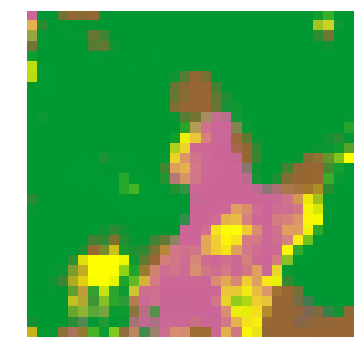

In [13]:
with open('coords'+str(x)+str(y)+str(bigsize), 'wb') as fp:
    pickle.dump(all_nns,fp)
final_image = np.zeros((bigsize,bigsize,3),dtype=int)
for i in range(final_labels.shape[0]):
    for j in range(final_labels.shape[1]):
        temp = final_labels[i,j]/np.sum(final_labels[i,j])
        temp *= 20
        temp = np.exp(temp)/np.sum(np.exp(temp))
        #print(temp)
        color = np.dot(temp,palette).astype(int)
        final_image[i,j] = color
plt.figure(figsize=(6,6))
plt.imshow(final_image)
plt.axis('off')
plt.show()
plt.close()

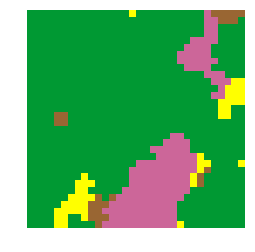

[[-254   -3    1 ...   39  103  103]
 [-277  -27    1 ... -139   87    1]
 [-178   -3    1 ...  -78    1    1]
 ...
 [   1    1    1 ...  -51  -11  -95]
 [ -10    2    2 ... -103 -101 -101]
 [-201   -4   -2 ... -102 -102 -101]]
0.896484375


In [14]:
gt = np.zeros((bigsize,bigsize,3),dtype=np.uint8)
for i in range(bigsize):
    for j in range(bigsize):
        gt[i,j] = palette[ground_truth[i,j]]
plt.figure()
plt.imshow(gt)
plt.axis('off')
plt.show()
plt.close()
tempsums = np.sum(gt-final_image,axis=2)
print(tempsums)
count = np.sum(tempsums<20)
print(count/bigsize**2)

In [32]:
flat = [item for sub in all_nns for item in sub]
ts = np.asarray(flat)[:,:3]
ts.shape
with open('coords'+str(x)+str(y), 'wb') as fp:
    pickle.dump(ts, fp)

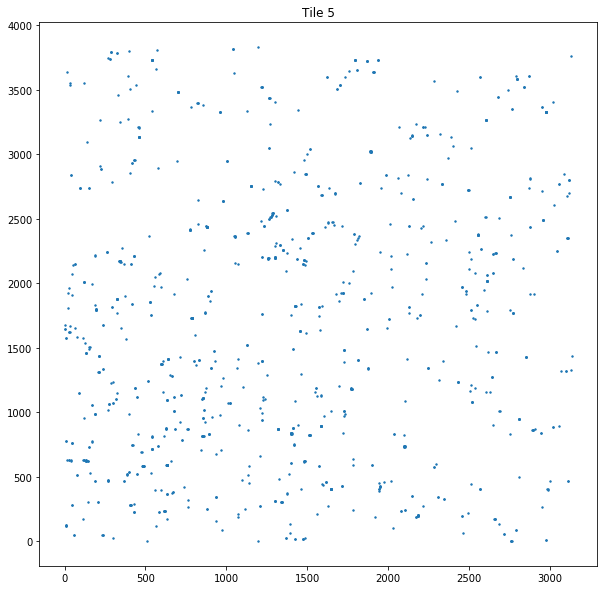

In [37]:

for tnum in searched_tiles:
    ts0 = []
    for i in range(len(ts)):
        if ts[i,0] == tnum:
            ts0.append([ts[i,1],ts[i,2]])
    xcoord,ycoord = zip(*ts0)
    plt.figure(figsize=(10,10))
    plt.scatter(ycoord,xcoord,s=2)
    plt.title('Tile '+str(tnum))
    plt.show()
    plt.close()

In [7]:
def get_labels_small(query,nns):
    coords = get_nns(np.arange(9)+1,query,nns)
    labels = np.zeros((size,size,len(coords)),dtype=int)
    for j in range(len(coords)):
        curr = coords[j]
        t,z1,z2 = curr[0],curr[1],curr[2]
        labels[:,:,j] = get_labels(t,z1,z2,size)
    qq = np.zeros((size,size,7),dtype=int)
    for i in range(size):
        for j in range(size):
            temp_bin = np.bincount(labels[i,j])
            qq[i,j] = np.pad(temp_bin,(0,7-len(temp_bin)),mode='constant')
    coords = np.array(coords).astype(float)
    print(qq.dtype)
    return qq, coords

def reconstruct(t,x,y,bigsize):
    query = get_query(t,x,y,bigsize)
    disp(query)
    disp_label(get_labels(t,x,y,bigsize))
    num_nns = 20
    result = np.zeros((bigsize,bigsize,7),dtype=int)
    grid_size = bigsize-size+1
    to_save = np.zeros((grid_size,grid_size,num_nns,4),dtype=np.float)
    for i in range(grid_size):
        for j in range(grid_size):
            temp_q = query[:,:,i:i+size,j:j+size]
            curr_bin, save_store = get_labels_small(temp_q,num_nns)
            result[i:i+size,j:j+size] += curr_bin
            to_save[i,j] = save_store
    return result,to_save

(8, 8, 7)


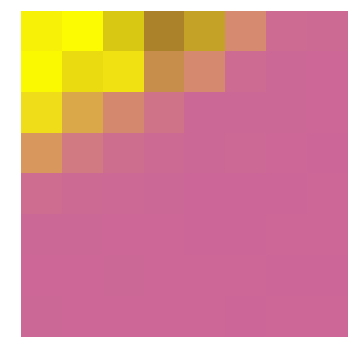

In [195]:
print(result.shape)
im = np.zeros((result.shape[0],result.shape[1],3),dtype=int)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        curr = result[i,j]/np.max(result[i,j])
        #ls, cs = np.unique(labels[:,i,j],return_counts=True)
        weight = 10
        cs = curr*weight
        #cs = np.array(cs)/np.sum(cs)*weight
        probs = np.exp(cs)/np.sum(np.exp(cs))
        #print(probs)
        im[i,j] = np.dot(probs,palette).astype(int)
plt.figure(figsize=(6,6))
plt.imshow(im)
plt.axis('off')
plt.show()
plt.close()

(10, 3, 1000, 1000)


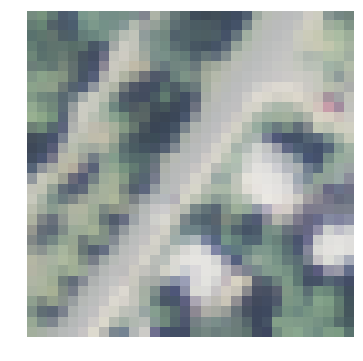

[[[ -968.77042253  -958.39640115  -953.40916084 ... -1631.67126314
   -1625.30623412 -1621.83899445]
  [ -956.83416769  -947.65682421  -943.85734255 ... -1609.97996513
   -1605.03195165 -1603.54448068]
  [ -947.19541858  -939.63577724  -937.16450259 ... -1588.74169482
   -1585.32235601 -1586.02107448]
  ...
  [-1201.68058557 -1216.25837571 -1229.77486602 ...  -875.77168523
    -884.09242504  -894.83501276]
  [-1175.26505198 -1188.4452494  -1200.3915929  ...  -869.50781648
    -877.49192673  -887.54473685]
  [-1142.86063277 -1155.25276148 -1166.52858958 ...  -856.36642579
    -864.09828125  -873.84252326]]

 [[-1281.20904024 -1298.44531554 -1315.02285119 ... -1214.04444623
   -1208.78740414 -1207.24390519]
  [-1277.32846794 -1295.38290043 -1313.63945559 ... -1212.81812322
   -1208.25389584 -1207.7424031 ]
  [-1286.27652437 -1305.59361257 -1325.09546782 ... -1210.02197981
   -1205.70632244 -1205.995282  ]
  ...
  [-1020.65035603 -1004.95209545  -980.17485781 ... -1283.51655123
   -1269.5

In [40]:
a = all_tiles[:,:,:1000,:1000]
print(a.shape)
new_size = 32
query = a[0,:,222:222+new_size,222:222+new_size]
query = np.expand_dims(query,axis=0)
disp(query)

a_squared = cum_sum(a**2,new_size)/new_size**2
a_sum = cum_sum(a,new_size)/new_size
a_sum_sq = a_sum**2
denom = np.sum(a_squared - a_sum_sq,axis=1)
print(denom)

tile_torch = torch.from_numpy(a).float().to(device)
query_torch = torch.from_numpy(query).float().to(device)
conv = torch.squeeze(F.conv2d(tile_torch,query_torch))
conv = conv.cpu().numpy()
q_mean = np.mean(query)

num_prod = np.sum(q_mean*a_sum,axis=1)

num = conv - num_prod

frac = num/denom
print(frac)

In [39]:
currmax = np.unravel_index(np.argmax(frac),(frac.shape))
print(currmax)

(5, 327, 344)


In [130]:
ts = np.reshape(to_save,(-1,4))[:,:3].astype(int)

In [131]:
ts.shape

(6400, 3)

In [44]:
%%time
conv0 = conv_lookup(np.arange(10),subpatches[:max_load,:,:,:],device0)

CPU times: user 13.1 s, sys: 8.1 s, total: 21.2 s
Wall time: 21.2 s


In [17]:
arr = np.reshape(np.arange(100),(1,1,10,10))
cs = cum_sum(arr,5)
print(cs)
arr_t = torch.from_numpy(arr).float()
onemat = torch.ones((1,1,5,5),dtype=torch.float)
conv = F.conv2d(arr_t,onemat)
print(conv)

[[[[ 550  575  600  625  650  675]
   [ 800  825  850  875  900  925]
   [1050 1075 1100 1125 1150 1175]
   [1300 1325 1350 1375 1400 1425]
   [1550 1575 1600 1625 1650 1675]
   [1800 1825 1850 1875 1900 1925]]]]


RuntimeError: thnn_conv2d_forward is not implemented for type torch.IntTensor

In [31]:
%%time
arr = np.reshape(np.arange(1000000),(1,1,1000,1000))
for i in range(10):
    cs = cum_sum(arr,32)
print(cs)

[[[[  15887872   15888896   15889920 ...   16877056   16878080
      16879104]
   [  16911872   16912896   16913920 ...   17901056   17902080
      17903104]
   [  17935872   17936896   17937920 ...   18925056   18926080
      18927104]
   ...
   [1005071872 1005072896 1005073920 ... 1006061056 1006062080
    1006063104]
   [1006095872 1006096896 1006097920 ... 1007085056 1007086080
    1007087104]
   [1007119872 1007120896 1007121920 ... 1008109056 1008110080
    1008111104]]]]
CPU times: user 170 ms, sys: 43.4 ms, total: 214 ms
Wall time: 213 ms


In [35]:
%%time
arr_t = torch.from_numpy(arr)
#onemat = torch.ones((1,1,32,32),dtype=torch.float)
for i in range(10):
    conv = torch.from_numpy(cum_sum(arr_t,32))
print(conv)

tensor([[[[  15887872,   15888896,   15889920,  ...,   16877056,
             16878080,   16879104],
          [  16911872,   16912896,   16913920,  ...,   17901056,
             17902080,   17903104],
          [  17935872,   17936896,   17937920,  ...,   18925056,
             18926080,   18927104],
          ...,
          [1005071872, 1005072896, 1005073920,  ..., 1006061056,
           1006062080, 1006063104],
          [1006095872, 1006096896, 1006097920,  ..., 1007085056,
           1007086080, 1007087104],
          [1007119872, 1007120896, 1007121920,  ..., 1008109056,
           1008110080, 1008111104]]]])
CPU times: user 657 ms, sys: 81.6 ms, total: 739 ms
Wall time: 738 ms


In [7]:
torch.cuda.empty_cache()

In [41]:
tt = torch.ones(10,10).to(device0)
ww = torch.Tensor([.5]).to(device0)
ss = .5
tt = torch.add(tt,ss)
print(tt)

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000]], device='c

In [10]:
%%time
for i in range(1000):
    tt+ww

CPU times: user 2.15 s, sys: 1.47 s, total: 3.62 s
Wall time: 3.62 s


In [9]:
%%time
for i in range(1000):
    tt+ss

CPU times: user 2.31 s, sys: 1.51 s, total: 3.82 s
Wall time: 3.81 s


In [20]:
query = subpatches[2:7,:,:,:]

query_squared = torch.Tensor([np.sum(query**2)]).float().to(device0)
conv = F.conv2d(tile_torch[np.arange(10),:,:,:],torch.from_numpy(query).float().to(device0))
torch.cuda.empty_cache()
conv = torch.transpose(conv,0,1)
##conv = conv.cpu().numpy()

##conv = np.rollaxis(conv,1,0)
#time0 = float(time.time())
conv = torch.add(tiles_squared[np.arange(10),:,:],-2,conv)
torch.cuda.empty_cache()
conv = torch.add(conv,query_squared)
torch.cuda.empty_cache()
#print(float(time.time())-time0,conv.shape)

#print(conv0.shape)

In [13]:
#del conv
torch.cuda.empty_cache()

In [31]:
tt = torch.randn((5,5))
print(torch.argmin(tt))

tensor(16)
